In [1]:
### BLOOMBERG EFFECTIVE EXCHANGE RATE SOURCES COMPARING

In [2]:
### INITIALIZATION

import pandas as pd
import matplotlib.pyplot as plt

In [3]:
### GENERAL DATA PREPARATION

### Constants:
All = slice(None)
### Factors sources:
str_path_bb_eer_source = 'Data_Files/Source_Files/Bloomberg_EER.xlsx'
str_path_bb_fx_source = 'Data_Files/Source_Files/Bloomberg_FX.xlsx'
dict_eer_sources = {'JPM REER B C D': 'REER 01-JPM', 'CTG REER B D': 'REER 02-CTG', 'IMF REER B M': 'REER 03-IMF', 'BIS REER B M': 'REER 04-BIS',
                    'JPM NEER B D': 'NEER 01-JPM', 'CTG REER B D (2)': 'NEER 02-CTG', 'BIS NEER B D': 'NEER 03-BIS'}
### Factors parameters:
list_truncate = [2.5, 2.0]
int_numer_ma_win = 21 * 3
int_denom_ma_win = 252 * 5
int_short_diff = 21 * 3
### Basics for efficacy measures calculating:
path_market_cap = 'Data_Files/Source_Files/Market_Cap.h5'
key_market_cap = 'mcap'
path_return = 'Data_Files/Source_Files/Returns_Integrated.h5'
key_return = 'returns'
### Export parameters:
str_path_neer_export = 'Data_Files/Test_Files/Saved_NEER.xlsx'
str_path_reer_export = 'Data_Files/Test_Files/Saved_REER.xlsx'
str_path_fx_export = 'Data_Files/Test_Files/Saved_FX.xlsx'

In [4]:
### DEFINING EXTRACTION BLOOMBERG EER DATA FROM GENERAL MS EXCEL SOURCE

def get_eer_data_excel(str_path_bb_eer_source, dict_eer_sources):
    ### Loading raw excel source:
    dict_eer_source = pd.read_excel(io = str_path_bb_eer_source, sheet_name = None, skiprows = list(range(4)), index_col = 0, header = 0, parse_dates = True, 
                                    na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                 '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False)
    ### Preparing datasets concatenation:
    arr_eer_data = []
    for str_sheet_name in dict_eer_source:
        ### Filtering Broad NEER or Broad CPI-Based REER:
        if str_sheet_name in dict_eer_sources:
            ### Future additional indexes:
            list_iter_index = dict_eer_sources[str_sheet_name].split()
            ### Stacking county codes for making series:
            ser_iter_set = dict_eer_source[str_sheet_name].stack(dropna = False)
            ### Main index levels renaming:
            ser_iter_set.index.names = ['Date', 'Country']
            ### Adding index levels for source description:
            ser_iter_set = ser_iter_set.to_frame().assign(Type = list_iter_index[0])\
                                                  .assign(Source = list_iter_index[1])\
                                                  .set_index(['Type', 'Source'], append = True).squeeze()
            ### Data aggregation for concatenation:
            arr_eer_data.append(ser_iter_set)
    ### Consolidated dataset preparing:
    ser_eer_data = pd.concat(arr_eer_data).reorder_levels([2, 3, 0, 1])
    ### Results output:
    return ser_eer_data

In [5]:
### DEFINING EXTRACTION BLOOMBERG EER DATA FROM GENERAL MS EXCEL SOURCE

def get_fx_data_excel(str_path_bb_fx_source):
    ### Loading raw excel source:
    df_fx_source = pd.read_excel(io = str_path_bb_fx_source, sheet_name = 'FX Data', skiprows = list(range(7)), index_col = 0, header = 0, parse_dates = True, 
                                    na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                                 '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null', '#N/A Invalid Security'], keep_default_na = False)
    ### Preparing for output:
    ser_fx_data = df_fx_source.stack(dropna = False)
    ser_fx_data.index.names = ['Date', 'Country']
    ser_fx_data.name = 'FX'    
    ### Results output:
    return ser_fx_data

In [7]:
### MAIN SCRIPT

### Dataset extraction from source:
ser_eer_data = get_eer_data_excel(str_path_bb_eer_source, dict_eer_sources)
ser_fx_data = get_fx_data_excel(str_path_bb_fx_source)
#ser_ison_membership = get_market_membership_from_excel()
#set_ison_countries = set(ser_ison_membership.index.get_level_values(1).unique())

In [8]:
### EER: FULL GENERAL STATISTICS CALCULATING:

arr_eer_stats = []
### Looping over types:
for iter_type in ser_eer_data.index.get_level_values(0).unique():
    dict_type_stats = {}
    dict_type_countries = {}
    ### Preliminary looping over sources inside the type for countries lists creating:
    for iter_source in ser_eer_data.loc[iter_type, All, All, All].index.get_level_values(0).unique():
        ser_iter_eer = ser_eer_data.loc[iter_type, iter_source, All, All].dropna()
        dict_type_countries[iter_source] = set(ser_iter_eer.index.get_level_values(-1).unique())
    set_type_sources = set(dict_type_countries.keys())
    ### Looping over sources inside the type:            
    for iter_source in ser_eer_data.loc[iter_type, All, All, All].index.get_level_values(0).unique():            
        dict_iter_stats = {}
        ### Data filtering by type and source:
        ser_iter_eer = ser_eer_data.loc[iter_type, iter_source, All, All].dropna()
        ### General stats:
        dict_iter_stats['Non-empty observations'] = [ser_iter_eer.count()]        
        dict_iter_stats['Earliest date'] = [sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[0].strftime('%Y-%m-%d')]
        dict_iter_stats['Latest date'] = [sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[-1].strftime('%Y-%m-%d')]   
        dict_iter_stats['Dates between'] = [(sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[-1] -\
                                            sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[0]).days]    
        ### Country grouping:
        ser_iter_country_count = ser_iter_eer.groupby('Country').count()
        dict_iter_stats['Non-empty countries number'] = [ser_iter_country_count.count()]
        dict_iter_stats['Average observations for country'] = [round(ser_iter_country_count.mean())]
        ### Cross-section:
        ser_iter_date_count = ser_iter_eer.groupby('Date').count()
        dict_iter_stats['Non-empty dates number'] = [ser_iter_date_count.count()]
        dict_iter_stats['Average observations for date'] = [round(ser_iter_date_count.mean())]        
        ### Unique countries for particular source:
        set_others = set()
        for iter_other in dict_type_countries:
            if (iter_other != iter_source):
                set_others = set_others | dict_type_countries[iter_other]
        list_iter_unique = sorted(dict_type_countries[iter_source] - set_others)
        dict_iter_stats['Unique countries'] = [len(list_iter_unique)]
        ### Converting data to oneline dataframe for future collecting:
        dict_type_stats[iter_source] = pd.DataFrame.from_dict(dict_iter_stats, orient = 'index', columns = [iter_type])
    ### Total stats for particular type:
    dict_iter_stats = {}
    ser_iter_eer = ser_eer_data.loc[iter_type, All, All, All].dropna().groupby(['Date', 'Country']).mean()
    ### General stats:
    dict_iter_stats['Non-empty observations'] = [ser_iter_eer.count()]        
    dict_iter_stats['Earliest date'] = [sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[0].strftime('%Y-%m-%d')]
    dict_iter_stats['Latest date'] = [sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[-1].strftime('%Y-%m-%d')]   
    dict_iter_stats['Dates between'] = [(sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[-1] -\
                                        sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[0]).days]    
    ### Country grouping:
    ser_iter_country_count = ser_iter_eer.groupby('Country').count()
    dict_iter_stats['Non-empty countries number'] = [ser_iter_country_count.count()]
    dict_iter_stats['Average observations for country'] = [round(ser_iter_country_count.mean())]
    ### Cross-section:
    ser_iter_date_count = ser_iter_eer.groupby('Date').count()
    dict_iter_stats['Non-empty dates number'] = [ser_iter_date_count.count()]
    dict_iter_stats['Average observations for date'] = [round(ser_iter_date_count.mean())]        
    ### Unique countries for particular source:
    dict_iter_stats['Unique countries'] = [ser_iter_country_count.count()]
    ### Converting data to oneline dataframe for future collecting:
    dict_type_stats['Total (mean)'] = pd.DataFrame.from_dict(dict_iter_stats, orient = 'index', columns = [iter_type])    
    ### Collecting stats for source:
    arr_eer_stats.append(pd.concat(dict_type_stats, axis = 1, sort = False).swaplevel(axis = 1))    
### Statistics aggregating:
df_eer_stats = pd.concat(arr_eer_stats, axis = 1)
### Statistics output:
print('Full general statistics:')
df_eer_stats

Full general statistics:


NEER                          \
                                      03-BIS      01-JPM      02-CTG   
Non-empty observations                352464      362124      291286   
Earliest date                     1996-04-11  1994-01-04  1990-01-01   
Latest date                       2020-05-26  2020-06-02  2020-06-02   
Dates between                           8811        9646       11110   
Non-empty countries number                56          55          51   
Average observations for country        6294        6584        5711   
Non-empty dates number                  6294        6621        7937   
Average observations for date             56          55          37   
Unique countries                          18           8           3   

                                                     REER              \
                                 Total (mean)      04-BIS      01-JPM   
Non-empty observations                 514814       17696      362097   
Earliest date                      1990-01-01  1994-01-31  1994-01-04   
Latest date                        2020-06-02  2020-04-30  2020-06-02   
Dates between                           11110        9586        9646   
Non-empty countries number                 77          56          55   
Average observations for country         6686         316        6584   
Non-empty dates number                   7937         316        6620   
Average observations for date              65          56          55   
Unique countries                           77           3           4   

                                                                       
                                      02-CTG      03-IMF Total (mean)  
Non-empty observations                291286       19795       412404  
Earliest date                     1990-01-01  1990-01-31   1990-01-01  
Latest date                       2020-06-02  2020-04-30   2020-06-02  
Dates between                          11110       11047        11110  
Non-empty countries number                51          55           78  
Average observations for country        5711         360         5287  
Non-empty dates number                  7937         364         8041  
Average observations for date             37          54           51  
Unique countries                           1           1           78

In [9]:
### EER: PREPARING COMBINED RAW DATA

### REER filtering:
df_reer_data = ser_eer_data.loc['REER', All, All, All].unstack('Source').sort_index(axis = 1)
### REER sources looping:
dict_reer_combined = {}
set_prev_countries = set()
for iter_source in df_reer_data.columns:
    ### Selecting unique REER source countries
    set_iter_countries = set(df_reer_data[iter_source].dropna().index.get_level_values(1).unique()) - set_prev_countries
    set_prev_countries = set_prev_countries | set_iter_countries
    print('REER:', iter_source, len(set_iter_countries), set_iter_countries)
    ### Creating dataset from REER source:
    dict_reer_combined[iter_source.split('-')[1]] = df_reer_data[iter_source].loc[All, set_iter_countries]
### REER combined source creating:
df_reer_combined = pd.concat(dict_reer_combined).reset_index(0).sort_index(level = ['Country', 'Date'])
df_reer_combined.columns = ['Source', 'Rate']
df_reer_combined.sort_index(level = ['Rate', 'Source'], axis = 1, inplace = True)   
### REER dataset saving to xlsx:
#df_reer_combined.to_excel(str_path_reer_export, merge_cells = False)
### NEER filtering:
df_neer_data = ser_eer_data.loc['NEER', All, All, All].unstack('Source').sort_index(axis = 1)
### NEER sources looping:
dict_neer_combined = {}
set_prev_countries = set()
for iter_source in df_neer_data.columns:
    ### Selecting unique NEER source countries    
    set_iter_countries = set(df_neer_data[iter_source].dropna().index.get_level_values(1).unique()) - set_prev_countries
    set_prev_countries = set_prev_countries | set_iter_countries
    print('NEER:', iter_source, len(set_iter_countries), set_iter_countries)    
    ### Creating dataset from NEER source:    
    dict_neer_combined[iter_source.split('-')[1]] = df_neer_data[iter_source].loc[All, set_iter_countries]
### NEER combined source creating:    
df_neer_combined = pd.concat(dict_neer_combined).reset_index(0).sort_index(level = ['Country', 'Date'])
df_neer_combined.columns = ['Source', 'Rate']
df_neer_combined.sort_index(level = ['Rate', 'Source'], axis = 1, inplace = True)
### NEER ataset saving to xlsx:
#df_neer_combined.to_excel(str_path_neer_export, merge_cells = False)

REER: 01-JPM 55 {'CL', 'ID', 'TR', 'GB', 'HR', 'JO', 'BR', 'ZM', 'HU', 'PA', 'RO', 'PE', 'EG', 'MY', 'JP', 'HK', 'KW', 'NZ', 'CN', 'MX', 'CH', 'RS', 'IL', 'PL', 'EC', 'AU', 'KE', 'BG', 'TN', 'IN', 'AR', 'MA', 'CZ', 'PK', 'DK', 'SE', 'NG', 'RU', 'VN', 'TH', 'CA', 'CO', 'KR', 'KZ', 'GH', 'SA', 'NO', 'PH', 'SG', 'TW', 'UA', 'UG', 'QA', 'ZA', 'US'}
REER: 02-CTG 4 {'OM', 'CR', 'BH', 'AE'}
REER: 03-IMF 16 {'ES', 'CI', 'NL', 'MT', 'BE', 'GR', 'IT', 'FR', 'FI', 'CY', 'SK', 'AT', 'DE', 'LV', 'IE', 'PT'}
REER: 04-BIS 3 {'SI', 'LT', 'EE'}
NEER: 01-JPM 55 {'CL', 'ID', 'TR', 'GB', 'HR', 'JO', 'BR', 'ZM', 'HU', 'PA', 'RO', 'PE', 'EG', 'MY', 'JP', 'HK', 'KW', 'NZ', 'CN', 'MX', 'CH', 'RS', 'IL', 'PL', 'EC', 'AU', 'KE', 'BG', 'TN', 'IN', 'AR', 'MA', 'CZ', 'PK', 'DK', 'SE', 'NG', 'RU', 'VN', 'TH', 'CA', 'CO', 'KR', 'KZ', 'GH', 'SA', 'NO', 'PH', 'SG', 'TW', 'UA', 'UG', 'QA', 'ZA', 'US'}
NEER: 02-CTG 4 {'OM', 'CR', 'BH', 'AE'}
NEER: 03-BIS 18 {'ES', 'NL', 'MT', 'BE', 'GR', 'DE', 'EE', 'IT', 'FR', 'FI', 'L

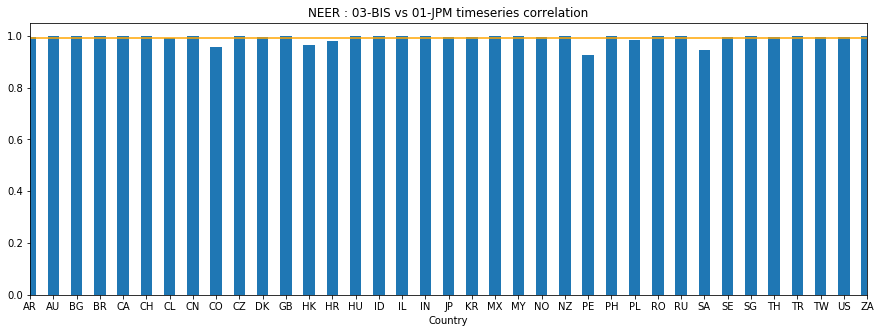

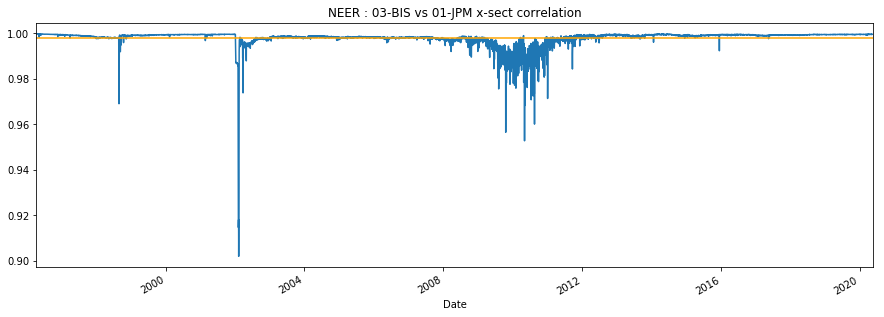

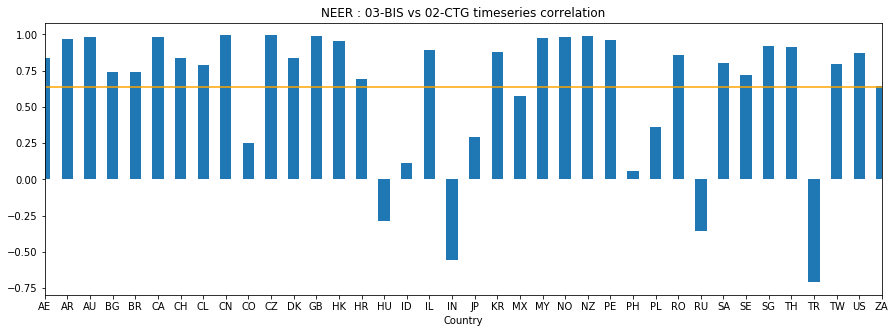

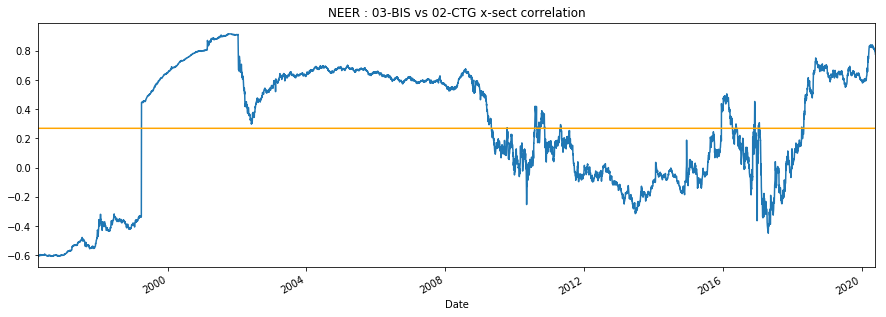

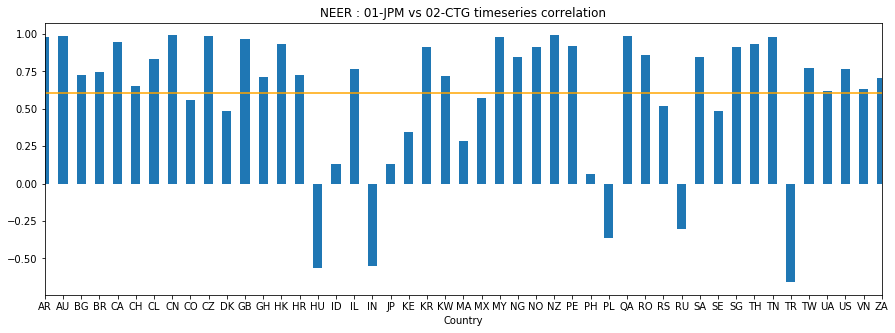

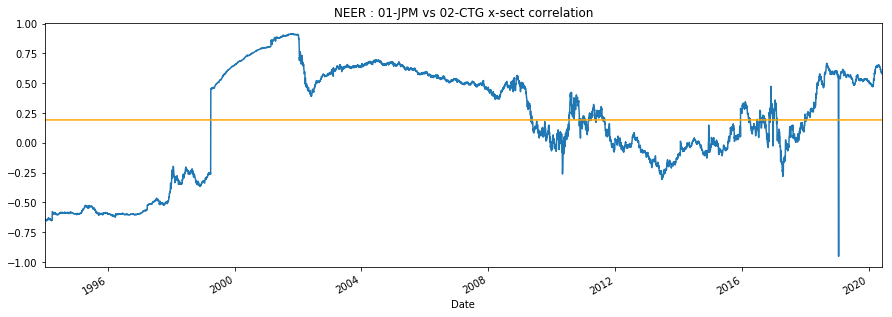

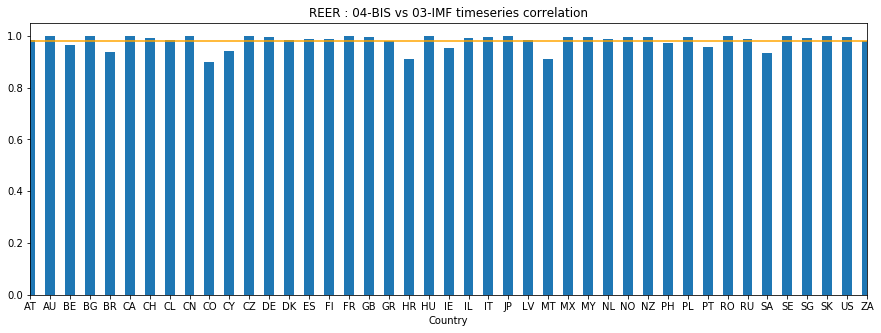

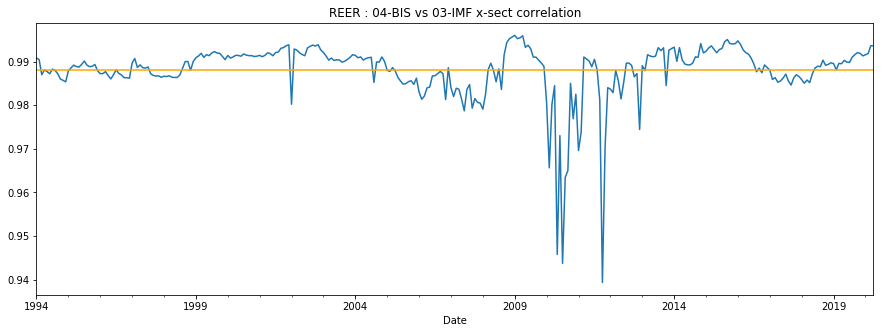

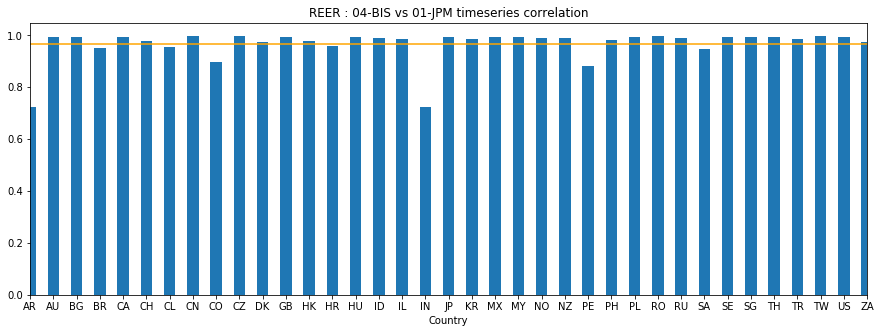

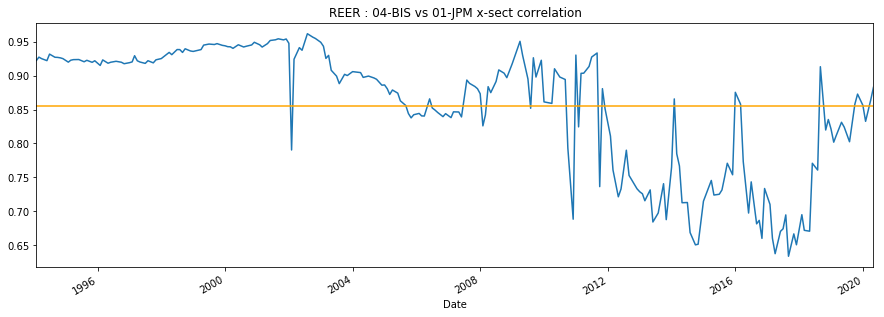

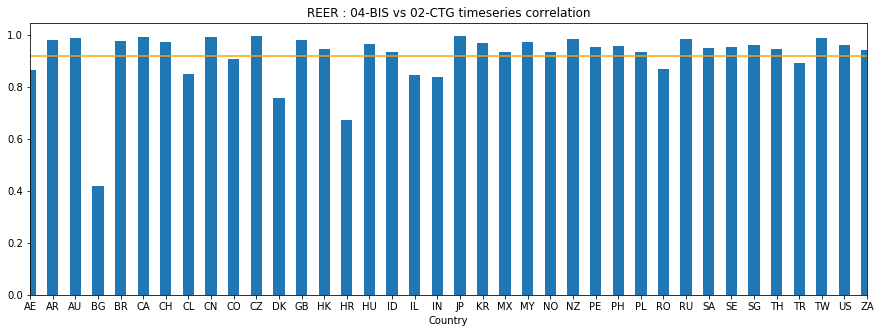

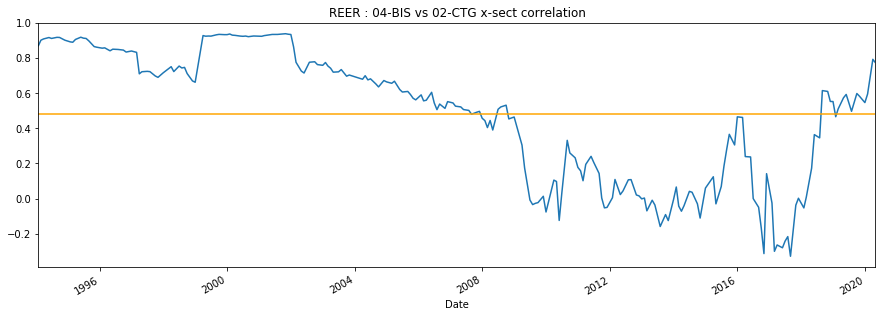

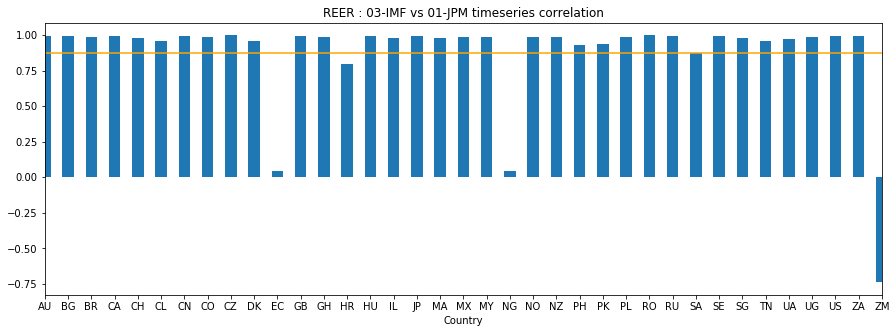

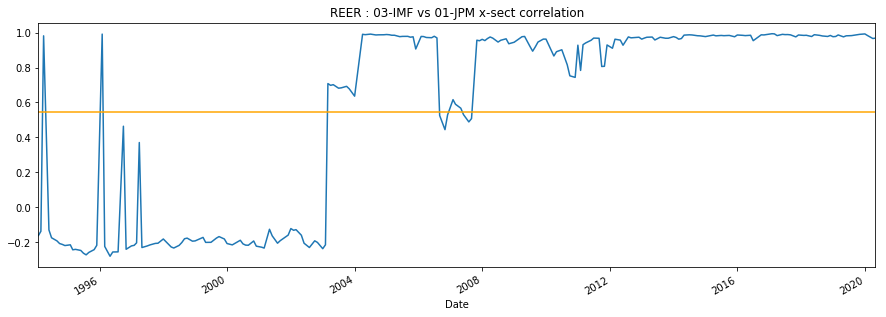

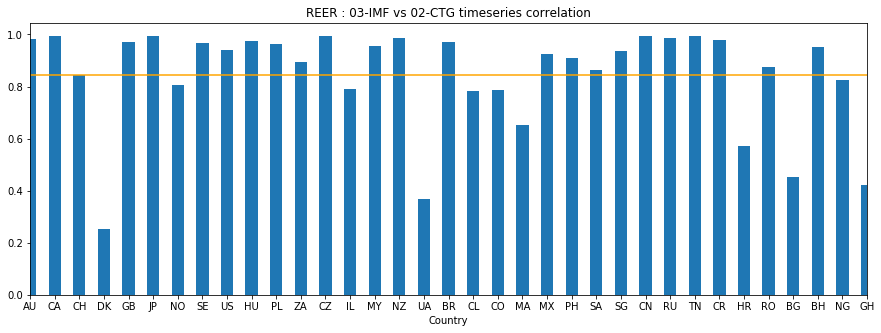

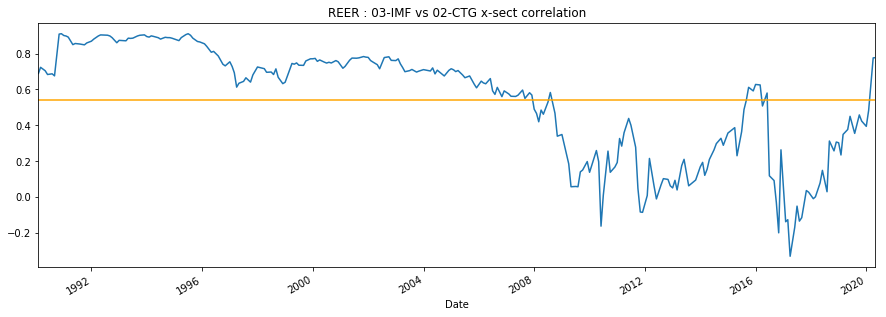

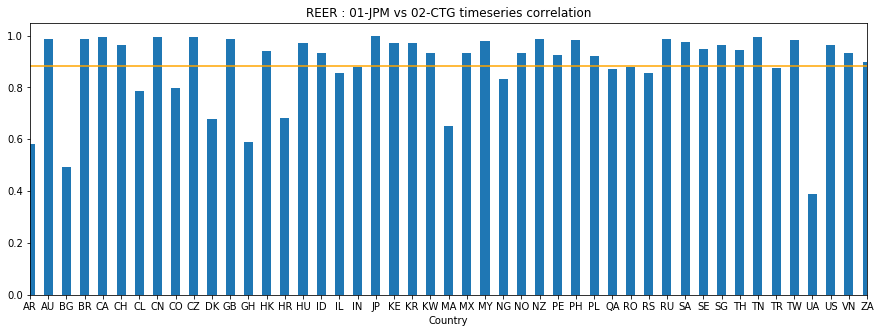

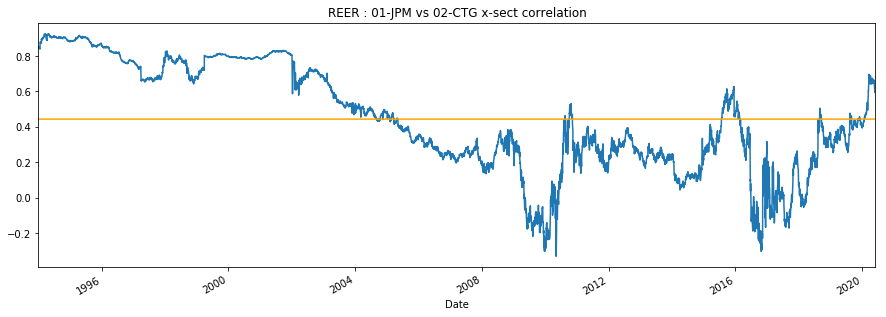

In [17]:
### EER: CORRELLATION STATISTICS GENERATING:

### Looping over types:
for iter_type in ser_eer_data.index.get_level_values(0).unique():
    ### Looping over sources inside the type:            
    set_sources = set(ser_eer_data.loc[iter_type, All, All, All].dropna().index.get_level_values(0).unique())
    while(set_sources):
        iter_main_source  = set_sources.pop()
        ### Looping over other sources to compare with looped one by country and by date:
        for iter_other_source in set_sources:
            df_iter_source = ser_eer_data.loc[iter_type, [iter_main_source, iter_other_source], All, All].dropna().droplevel('Type').unstack('Source')
            ### By country bilateral correlation:
            ser_iter_country_corr = df_iter_source.groupby('Country').corr().loc[(All, iter_main_source), iter_other_source].droplevel('Source').dropna()
            ser_iter_country_corr.plot.bar(figsize = (15, 5), color = '#1f77b4', 
                                           title = iter_type + ' : ' + iter_main_source + ' vs ' + iter_other_source + ' timeseries correlation')
            pd.Series(ser_iter_country_corr.mean(), index = ser_iter_country_corr.index).plot(color = 'Orange')            
            plt.show()            
            ### By date bilateral correlation:
            ser_iter_x_sect_corr = df_iter_source.groupby('Date').corr().loc[(All, iter_main_source), iter_other_source].droplevel('Source').dropna()            
            ser_iter_x_sect_corr.plot(figsize = (15, 5), color = '#1f77b4', 
                                      title = iter_type + ' : ' + iter_main_source + ' vs ' + iter_other_source + ' x-sect correlation') 
            pd.Series(ser_iter_x_sect_corr.mean(), index = ser_iter_x_sect_corr.index).plot(color = 'Orange')            
            plt.show()  

In [ ]:
### EER: LIMITED GENERAL STATISTICS CALCULATING:

arr_eer_stats = []
### Excluding NEER/CTG source & REER/BB source
ser_eer_limited = pd.concat([ser_eer_data.loc['NEER', ['BB', 'JPM'], All, All], ser_eer_data.loc['REER', ['CTG', 'JPM'], All, All]])
ser_eer_limited.groupby(['Type', 'Source']).count()
### Looping over types:
for iter_type in ser_eer_limited.index.get_level_values(0).unique():
    dict_type_stats = {}
    dict_type_countries = {}
    ### Preliminary looping over sources inside the type for countries lists creating:
    for iter_source in ser_eer_limited.loc[iter_type, All, All, All].index.get_level_values(1).unique():
        ser_iter_eer = ser_eer_limited.loc[iter_type, iter_source, All, All].dropna()
        dict_type_countries[iter_source] = set(ser_iter_eer.index.get_level_values(-1).unique())
    set_type_sources = set(dict_type_countries.keys())
    ### Looping over sources inside the type:            
    for iter_source in ser_eer_limited.loc[iter_type, All, All, All].index.get_level_values(1).unique():            
        dict_iter_stats = {}
        ### Data filtering by type and source:
        ser_iter_eer = ser_eer_limited.loc[iter_type, iter_source, All, All].dropna()
        ### General stats:
        dict_iter_stats['Non-empty observations'] = [ser_iter_eer.count()]        
        dict_iter_stats['Earliest date'] = [sorted(list(ser_iter_eer.index.get_level_values(2).unique()))[0].strftime('%Y-%m-%d')]
        dict_iter_stats['Latest date'] = [sorted(list(ser_iter_eer.index.get_level_values(2).unique()))[-1].strftime('%Y-%m-%d')]   
        dict_iter_stats['Dates between'] = [(sorted(list(ser_iter_eer.index.get_level_values(2).unique()))[-1] -\
                                            sorted(list(ser_iter_eer.index.get_level_values(2).unique()))[0]).days]    
        ### Country grouping:
        ser_iter_country_count = ser_iter_eer.groupby('Country').count()
        dict_iter_stats['Non-empty countries number'] = [ser_iter_country_count.count()]
        dict_iter_stats['Average observations for country'] = [round(ser_iter_country_count.mean())]
        ### Cross-section:
        ser_iter_date_count = ser_iter_eer.groupby('Date').count()
        dict_iter_stats['Non-empty dates number'] = [ser_iter_date_count.count()]
        dict_iter_stats['Average observations for date'] = [round(ser_iter_date_count.mean())]        
        ### Unique countries for particular source:
        iter_others = list(filter(lambda l_source: l_source != iter_source, set_type_sources))
        list_iter_unique = sorted(dict_type_countries[iter_source] - dict_type_countries[iter_others[0]])
        dict_iter_stats['Unique countries'] = [len(list_iter_unique)]
        ### Converting data to oneline dataframe for future collecting:
        dict_type_stats[iter_source] = pd.DataFrame.from_dict(dict_iter_stats, orient = 'index', columns = [iter_type])
    ### Total stats for particular type:
    dict_iter_stats = {}
    ser_iter_eer = ser_eer_limited.loc[iter_type, All, All, All].dropna().groupby(['Date', 'Country']).mean()
    ### General stats:
    dict_iter_stats['Non-empty observations'] = [ser_iter_eer.count()]        
    dict_iter_stats['Earliest date'] = [sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[0].strftime('%Y-%m-%d')]
    dict_iter_stats['Latest date'] = [sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[-1].strftime('%Y-%m-%d')]   
    dict_iter_stats['Dates between'] = [(sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[-1] -\
                                        sorted(list(ser_iter_eer.index.get_level_values(0).unique()))[0]).days]    
    ### Country grouping:
    ser_iter_country_count = ser_iter_eer.groupby('Country').count()
    dict_iter_stats['Non-empty countries number'] = [ser_iter_country_count.count()]
    dict_iter_stats['Average observations for country'] = [round(ser_iter_country_count.mean())]
    ### Cross-section:
    ser_iter_date_count = ser_iter_eer.groupby('Date').count()
    dict_iter_stats['Non-empty dates number'] = [ser_iter_date_count.count()]
    dict_iter_stats['Average observations for date'] = [round(ser_iter_date_count.mean())]        
    ### Unique countries for particular source:
    dict_iter_stats['Unique countries'] = [ser_iter_country_count.count()]
    ### Converting data to oneline dataframe for future collecting:
    dict_type_stats['Total (mean)'] = pd.DataFrame.from_dict(dict_iter_stats, orient = 'index', columns = [iter_type])    
    ### Collecting stats for source:
    arr_eer_stats.append(pd.concat(dict_type_stats, axis = 1, sort = False).swaplevel(axis = 1))    
### Statistics aggregating:
df_eer_stats = pd.concat(arr_eer_stats, axis = 1)
### Statistics output:
print('Limited general statistics:')
df_eer_stats

In [ ]:
### EER: INFORMATION ABOUT EXCLUDING SOURCES: NEER / CTG (ONE UNIQUE COUNTRY) & REER / BB (TOO LATE DATA)

### NEER / Citygroup unique countries:
set_ctg_countries = set(ser_eer_data.loc['NEER', 'CTG', All, All].dropna().index.get_level_values(3).unique())
set_other_countries = set(ser_eer_data.loc['NEER', ['BB', 'JPM'], All, All].dropna().index.get_level_values(3).unique())
print('NEER / CTG unique countries:\n', sorted(set_ctg_countries.difference(set_other_countries)))
print('NEER overall missed countries (including unique ones from CTG):\n', sorted(set_ison_countries.difference(set_other_countries)))
### REER / Bloomberg unique countries:
set_bb_countries = set(ser_eer_data.loc['REER', 'BB', All, All].dropna().index.get_level_values(3).unique())
set_other_countries = set(ser_eer_data.loc['REER', ['CTG', 'JPM'], All, All].dropna().index.get_level_values(3).unique())
print('REER / BB unique countries:\n', sorted(set_bb_countries.difference(set_other_countries)))
print('REER overall missed countries (including unique ones from BB):\n', sorted(set_ison_countries.difference(set_other_countries)))